### pytorch tutorial
https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [4]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [5]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

100%|██████████| 26421880/26421880 [00:05<00:00, 4633936.47it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 110028.06it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:02<00:00, 1980461.95it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 7149760.59it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [6]:
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

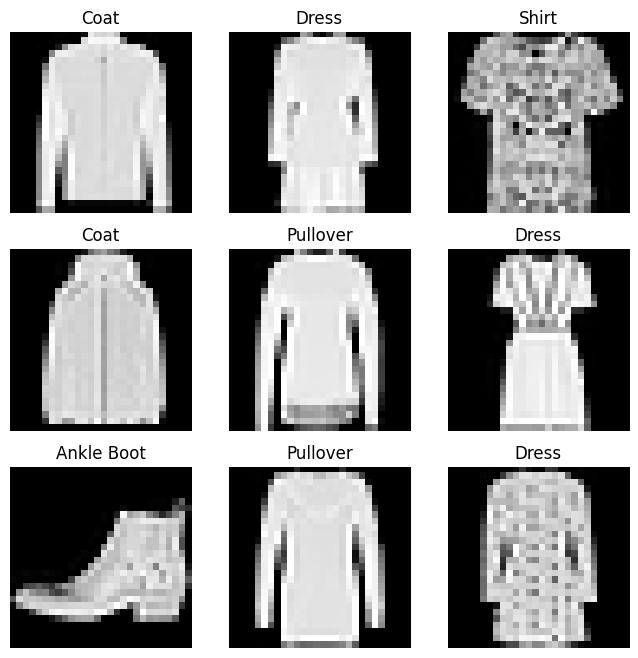

In [8]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8,8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(img.squeeze(), cmap='gray')
plt.show()

### Custom image dataset

In [10]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        if self.target_transform:
            label = self.target_transform(label)

        return image, label

In [18]:
# preparing data
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


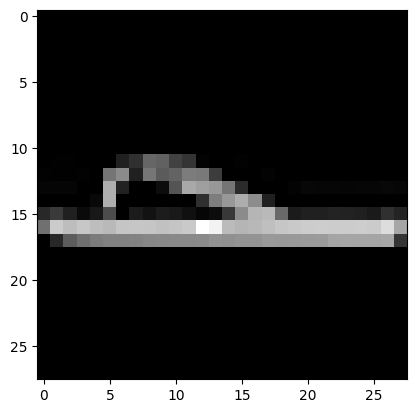

Label: 5


In [17]:
# iterating through the dataset

train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap='gray')
plt.show()
print(f"Label: {label}")

### creating the network

In [25]:
from torch import nn

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

Using cpu device


In [26]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [27]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


In [29]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.260051  [   64/60000]
loss: 2.246514  [ 6464/60000]
loss: 2.235452  [12864/60000]
loss: 2.200073  [19264/60000]
loss: 2.219819  [25664/60000]
loss: 2.170727  [32064/60000]
loss: 2.178085  [38464/60000]
loss: 2.139086  [44864/60000]
loss: 2.111670  [51264/60000]
loss: 2.113719  [57664/60000]
Test Error: 
 Accuracy: 52.4%, Avg loss: 2.087190 

Epoch 2
-------------------------------
loss: 2.079493  [   64/60000]
loss: 2.048742  [ 6464/60000]
loss: 2.023671  [12864/60000]
loss: 2.019861  [19264/60000]
loss: 1.987639  [25664/60000]
loss: 1.943586  [32064/60000]
loss: 1.886066  [38464/60000]
loss: 1.895599  [44864/60000]
loss: 1.880027  [51264/60000]
loss: 1.740587  [57664/60000]
Test Error: 
 Accuracy: 59.1%, Avg loss: 1.765760 

Epoch 3
-------------------------------
loss: 1.714108  [   64/60000]
loss: 1.716414  [ 6464/60000]
loss: 1.798977  [12864/60000]
loss: 1.647674  [19264/60000]
loss: 1.688489  [25664/60000]
loss: 1.657663  [32064/600

### Predicting

In [ ]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8,8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    predicted_label = model(img)
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(img.squeeze(), cmap='gray')
plt.show()

In [38]:
sample_idx = torch.randint(len(training_data), size=(1,)).item()
img, label = training_data[sample_idx]
predicted_label = model(img)
_, pred = torch.max(predicted_label,1)
pred = pred.item()
print(predicted_label)
print(pred.item())
print(label)


tensor([[ 1.9434,  4.8596, -0.3797,  3.6842,  0.4693, -2.5755,  0.4666, -3.4561,
         -2.5569, -3.1242]], grad_fn=<AddmmBackward0>)
1
1


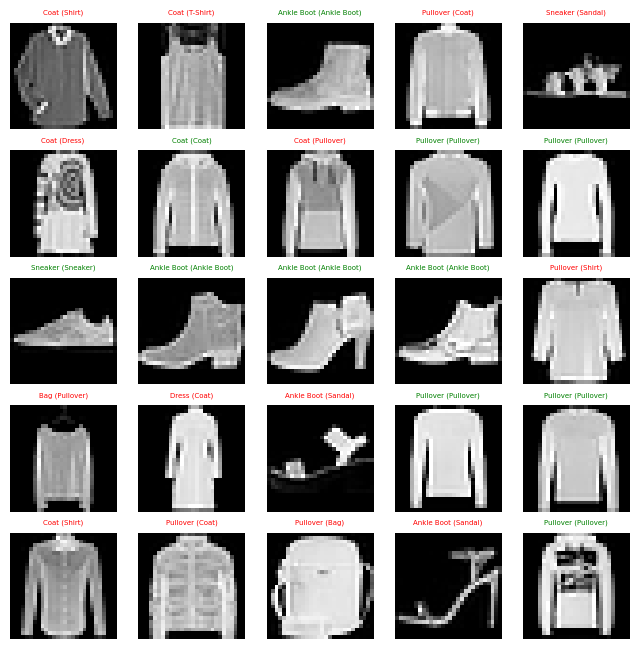

In [46]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8,8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    predicted_label = model(img)
    _, pred = torch.max(predicted_label,1)
    pred = pred.item()
    figure.add_subplot(rows, cols, i)
    plt.title(f"{labels_map[pred]} ({labels_map[label]})", color=("green" if pred==label else "red"), fontsize=5)
    plt.axis('off')
    plt.imshow(img.squeeze(), cmap='gray')
plt.show()